Andrew Dodd, 3/6/21

## Assignment 3: Overview

### Sections
  1. 2 clustering algos x 2 datasets
  2. 4 dim. red. methods x 2 datasets
  3. 2 clustering algos on 8 dim. red. datasets
  4. NN reruns on 4 dim. red. algos. on 1 dataset
  5. Repeat Step 4 but with clusters as features, add them to existing features
  _________
_________


####  Methods
2 Clustering methods:
- K-means
- Expectation Maximization

4 Dim. Red. Methods:
- PCA
- ICA
- Randomized Projections
- Forward Selection (my choice), can use feature importance here
_________

#### Notes:
- Use Pearson Correlation coefficient to discuss projected data effectiveness
- ICA - use Kurtosis to choose how many components (on ICA components), RMSE goes down, Kurtosis goes up


# 0. Imports and Data loading

In [11]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from time import time
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn import random_projection
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.stats import kurtosis
from scipy.spatial.distance import cdist

In [2]:
# Read data in
df = pd.read_csv("./data/diabetes.csv")

X = df.values[:,:-2]
y = df.values[:,-1]

X_train1_b, X_test1_b, y_train1_b, y_test1_b = train_test_split(X, y, test_size=0.2, random_state=42)
X_train1, X_test1, y_train1, y_test1 = X_train1_b, X_test1_b, y_train1_b, y_test1_b
y_train1_b.sum(), y_test1_b.sum()

scaler = StandardScaler()
scaler.fit(X_train1_b)
scaler.mean_
X_train1 = scaler.transform(X_train1_b)
print("Train: ", X_train1.shape, "Positive examples: ", y_train1.sum())

X_test1 = scaler.transform(X_test1_b)
print("Test: ", X_test1.shape, "Positive examples: ", y_test1.sum())

df1 = df.copy()
print(df.columns)

Train:  (614, 7) Positive examples:  213.0
Test:  (154, 7) Positive examples:  55.0
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [3]:
# Read data in
df = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_orig = df.copy()

# Change columns
df['tenure'] = pd.to_numeric(df['tenure'])
df = df.drop(['customerID'], axis=1)
df['MonthlyCharges'] = df['MonthlyCharges'].map(lambda x: float(x))
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'])
df['TotalCharges'] = df['TotalCharges'].map(lambda x: float(x) if x!=' ' else -9999)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# Feature engineering columns
"""
· “Long Term Bundle Client” = if( “tenure” > 24 months && “InternetService” != No && “PhoneService” == Yes), (Yes or No)
· “Bachelor Client” = if( “gender” == male && “Partner” == No && “Dependents” == No), (Yes or No)
· “New Family Client” = if( “Partner” == Yes && “Dependents” == Yes && “tenure” < 12 months), (Yes or No)
"""
df['Long Term Bundle Client'] = (df["tenure"]>24) & (df['InternetService']!='No') & (df['PhoneService']=='Yes')
df['Bachelor Client'] = (df['gender']=='Male') & (df['Partner']=='No') & (df['Dependents']=='No')
df['New Family Client'] = (df['Partner']=='Yes') & (df['Dependents']=='Yes') & (df['tenure']<12)
for col in ['Long Term Bundle Client', 'Bachelor Client', 'New Family Client']:
    df[col] = df[col].apply(lambda x: 1 if x else 0)

# Get dummies based on prev. dataframe
df = df.drop(['Churn'], axis=1)
df = pd.get_dummies(df)

df_orig['Churn'] = df_orig['Churn'].map({'No':0,'Yes':1})
pd.set_option('display.max_columns', 500)
df.values[0:1]

X = df.values
y = df_orig['Churn'].values

X_train2_b, X_test2_b, y_train2_b, y_test2_b = train_test_split(X, y, test_size=0.2, random_state=44)
X_train2, X_test2, y_train2, y_test2 = X_train2_b, X_test2_b, y_train2_b, y_test2_b
y_train2_b.sum(), y_test2_b.sum()

scaler = StandardScaler()
scaler.fit(X_train2_b)
scaler.mean_
X_train2 = scaler.transform(X_train2_b)
print("Train: ", X_train2.shape, "Positive examples: ", y_train2.sum())

X_test2 = scaler.transform(X_test2_b)
print("Test: ", X_test2.shape, "Positive examples: ", y_test2.sum())

df2 = df.copy()
print(df.columns)

Train:  (5634, 48) Positive examples:  1487
Test:  (1409, 48) Positive examples:  382
Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'Long Term Bundle Client', 'Bachelor Client', 'New Family Client',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'Streami

# 1. Two clustering algos x Two datasets

In [5]:
# Some code here based on: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
def getDistortionsGM(K, X):
    distortions = []
    for k in K:
        # Building and fitting the model
        gm = GaussianMixture(n_components=k, random_state=0).fit(X)
        closest = np.min(cdist(X, gm.means_, 'euclidean'), axis=1)
        distortions.append(sum(closest) / X.shape[0])
    return distortions

def makeDistortionPlotsGM(X1, X2, n, jump):
    K = list(range(1, n, jump))
    dists1 = getDistortionsGM(K, X1)
    dists2 = getDistortionsGM(K, X2)

    f, ax = plt.subplots(1,2, figsize=(14, 5))

    ax[0].plot(K, dists1, '-', color="b")
    ax[0].legend()
    ax[0].set_title("Distortion vs. # Components (Dataset 1)", fontsize=16)
    ax[0].set(xlabel='# Components', ylabel='Distortion')

    ax[1].plot(K, dists2, '-', color="b")
    ax[1].legend()
    ax[1].set_title("Distortion vs. # Components (Dataset 2)", fontsize=16)
    ax[1].set(xlabel='# Components', ylabel='Distortion')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


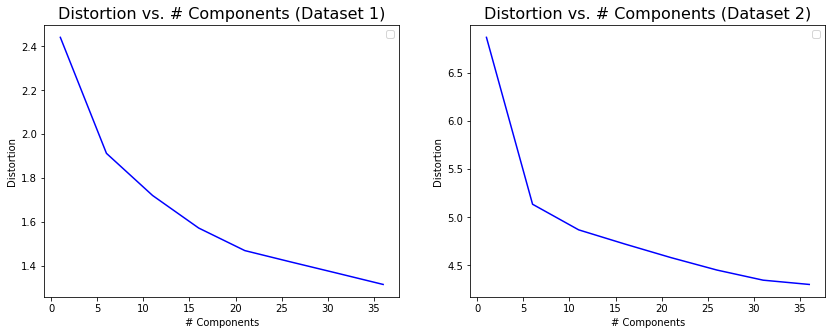

In [199]:
makeDistortionPlotsGM(X_train1, X_train2, 40, 5)

In [200]:
def getDistortionsKMeans(K, X):
    distortions = []
    for k in K:
        # Building and fitting the model
        km = KMeans(k, random_state=0).fit(X)
        closest = np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1)
        distortions.append(sum(closest) / X.shape[0])
    return distortions

def makeDistortionPlotsKMeans(X1, X2, n, jump):
    K = list(range(1, n, jump))
    dists1 = getDistortionsKMeans(K, X1)
    dists2 = getDistortionsKMeans(K, X2)

    f, ax = plt.subplots(1,2, figsize=(14, 5))

    ax[0].plot(K, dists1, '-', color="b")
    ax[0].legend()
    ax[0].set_title("Distortion vs. # Clusters (Dataset 1)", fontsize=16)
    ax[0].set(xlabel='# Clusters', ylabel='Distortion')

    ax[1].plot(K, dists2, '-', color="b")
    ax[1].legend()
    ax[1].set_title("Distortion vs. # Clusters (Dataset 2)", fontsize=16)
    ax[1].set(xlabel='# Clusters', ylabel='Distortion')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


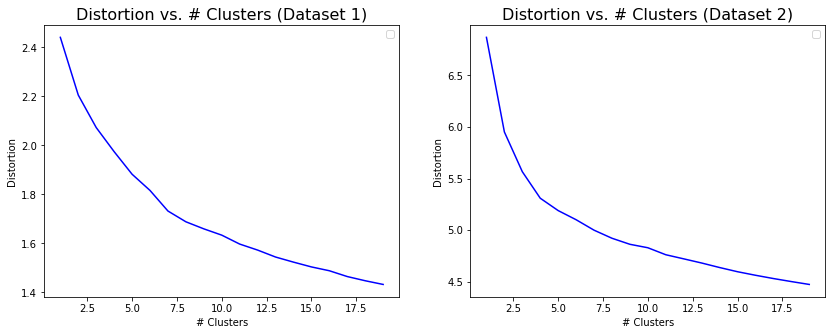

In [201]:
makeDistortionPlotsKMeans(X_train1, X_train2, 20, 1)

### Looking at the clusters given - Gaussian Mixture

array([[ 0.60696948, -0.36388968,  0.16761349,  0.68096363, -0.19387904,
        -0.09626988, -0.33006937],
       [ 0.31114217,  0.12462473,  0.30156465, -1.32277365, -0.70120553,
        -0.11396469, -0.20147412],
       [-0.36008469,  0.37178649,  0.37742296, -0.16295188, -0.1358314 ,
        -0.53115281, -0.46639104],
       [-0.01446688,  0.86183305,  0.10148171,  0.58935794,  1.85134882,
         0.47672562, -0.25114267],
       [-0.22433362, -0.15558296, -3.75268255, -1.17957438, -0.70120553,
        -0.66371552, -0.20488737],
       [-0.63956239,  0.81870549, -0.24699108,  0.94409422,  0.87458381,
        -0.05719102,  3.84614509],
       [-0.80004466, -0.38448928, -0.0853221 ,  0.69841373,  0.24982562,
         0.33412257, -0.17583429],
       [-0.85517373,  0.44690384,  0.87236028,  1.13175734,  0.38334784,
         1.28216077,  1.01123842],
       [-0.73517872, -0.7504213 , -0.32679236, -0.05964978, -0.20360458,
        -0.74792127, -0.06118686],
       [ 1.20441636,  0.5578

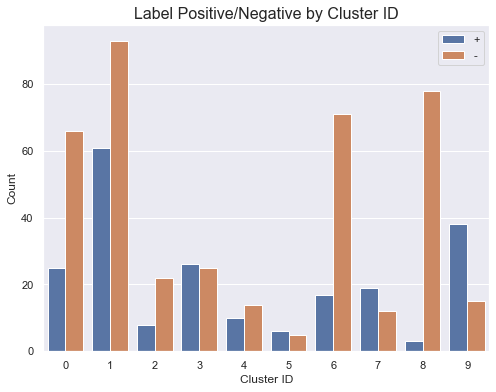

In [142]:
def makeCountVsCluster(X, y, model):
    gm = model.fit(X)
    pred = gm.predict(X)
    cnts = Counter()
    rang = range(0,10)
    n_pos = []
    n_neg = []
    for c in rang:
        cluster_mask = pred == c
        n_pos.append(y[cluster_mask].sum())
        n_neg.append(cluster_mask.sum() - y[cluster_mask].sum())
    df1 = pd.DataFrame({'cluster_id':rang, 'n':n_pos, 'pos':['+']*len(rang)})
    df2 = pd.DataFrame({'cluster_id':rang, 'n':n_neg, 'pos':['-']*len(rang)})
    df = pd.concat([df1, df2]).reset_index()

    sns.set(rc={'figure.figsize':(8,6)})
    ax = sns.barplot(x='cluster_id', y='n', data=df, hue='pos')
    ax.legend()
    ax.set_title("Label Positive/Negative by Cluster ID", fontsize=16)
    ax.set(xlabel='Cluster ID', ylabel='Count')

gm = GaussianMixture(n_components=10, random_state=0)
makeCountVsCluster(X_train1, y_train1, gm)

pred = gm.predict(X_train1)
cluster_mask = pred == 8
X_train1_b[cluster_mask]

# 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
#        'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
gm.means_

array([[-0.05646742,  0.6569136 ,  0.4543965 ,  0.71279652,  1.20505048],
       [-0.21841164, -0.40980295, -1.47405753, -0.77675535, -0.78319989],
       [ 0.31654723, -0.9365142 ,  0.64122301, -0.63594336, -0.78319989],
       [-0.12661461,  1.18938429,  0.69034808,  1.33921001,  1.27681326],
       [-0.02788284,  0.03726604, -0.74143228, -0.29813856, -0.78319989],
       [-0.31398918, -1.09374198, -0.01731559, -0.88875452, -0.78319989],
       [-0.44119892,  0.15856779, -1.44318803, -0.66840825, -0.78319989],
       [-0.06390582,  0.14556769,  0.16667509,  0.08467606,  0.87149317],
       [-0.2147325 , -0.92752514, -0.28963503, -0.73955366, -0.78319989],
       [ 0.4098518 ,  0.62987113,  1.01816043,  1.01320427,  1.27681326]])

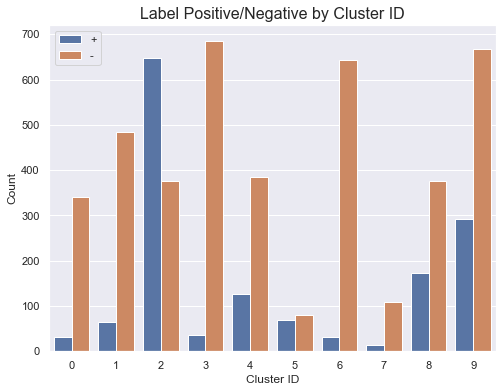

In [148]:
gm = GaussianMixture(n_components=10, random_state=0)
makeCountVsCluster(X_train2, y_train2, gm)

pred = gm.predict(X_train2)
cluster_mask = pred == 2

gm.means_[:, 0:5]

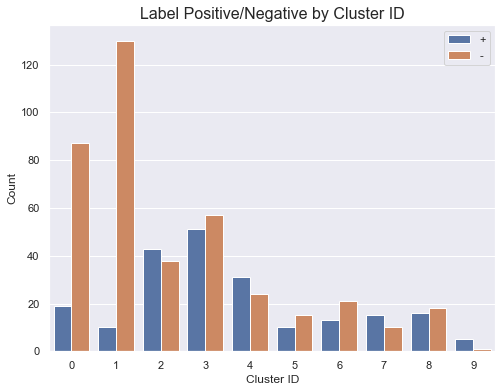

In [123]:
gm = KMeans(10, random_state=0)
makeCountVsCluster(X_train1, y_train1, gm)

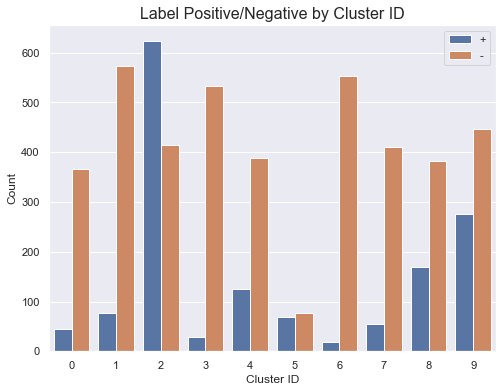

In [124]:
gm = KMeans(10, random_state=0)
makeCountVsCluster(X_train2, y_train2, gm)

# 2. Four Dim. Red. Methods on 2 Datasets

### 2.1 PCA

In [15]:
# (From https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py)

def makePlots(n, X):
    f, ax = plt.subplots(1,3, figsize=(14, 5))

    pca = PCA(n_components=n)
    pca.fit(X)

    sns.barplot(x=list(range(1,n+1)), y=pca.explained_variance_, ax=ax[0])
    ax[0].set_title("Variance by # Components", fontsize=16)
    ax[0].set(xlabel="# Components", ylabel="Variance Explained")

    pca = PCA(n_components=2)
    pca.fit(X)

    ax[1].scatter(X[:, 0], X[:, 1], alpha=.3, label='samples')
    for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
        comp = comp * var  # scale component by its variance explanation power
        ax[1].plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
                 color=f"C{i + 2}")
    ax[1].legend()
    ax[1].set_title("Visual. PCA - First Two Comp.", fontsize=16)
    ax[1].set(xlabel="First Dataset Feature", ylabel="Second Dataset Feature")

    ax[2].scatter(X.dot(pca.components_[0]), X.dot(pca.components_[1]), alpha=.3, label='samples')
    ax[2].set_title("PCA first two dimensions", fontsize=16)
    ax[2].set(xlabel='First principal component', ylabel='Second principal component')

    plt.show()

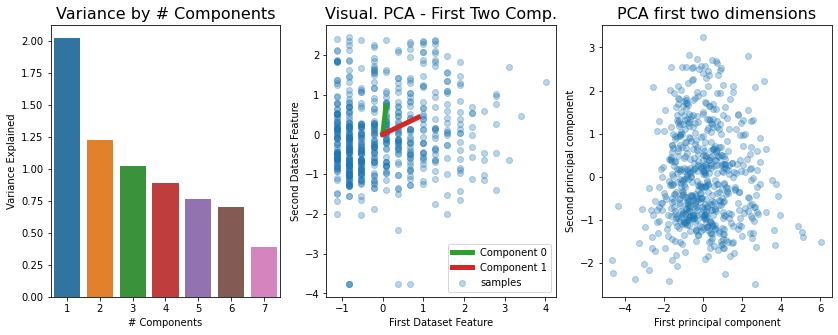

In [16]:
makePlots(7, X_train1)

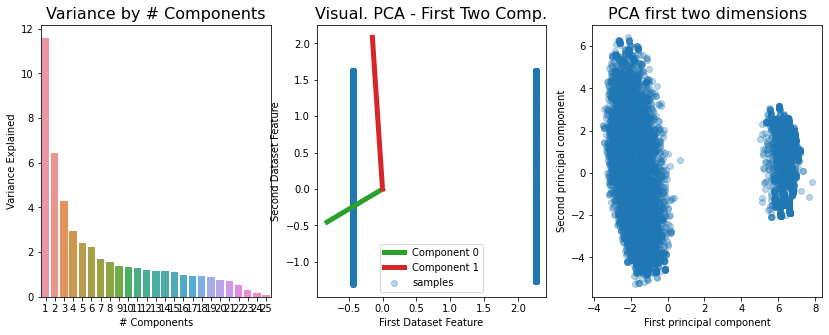

In [17]:
makePlots(25, X_train2)

### 2.2 ICA

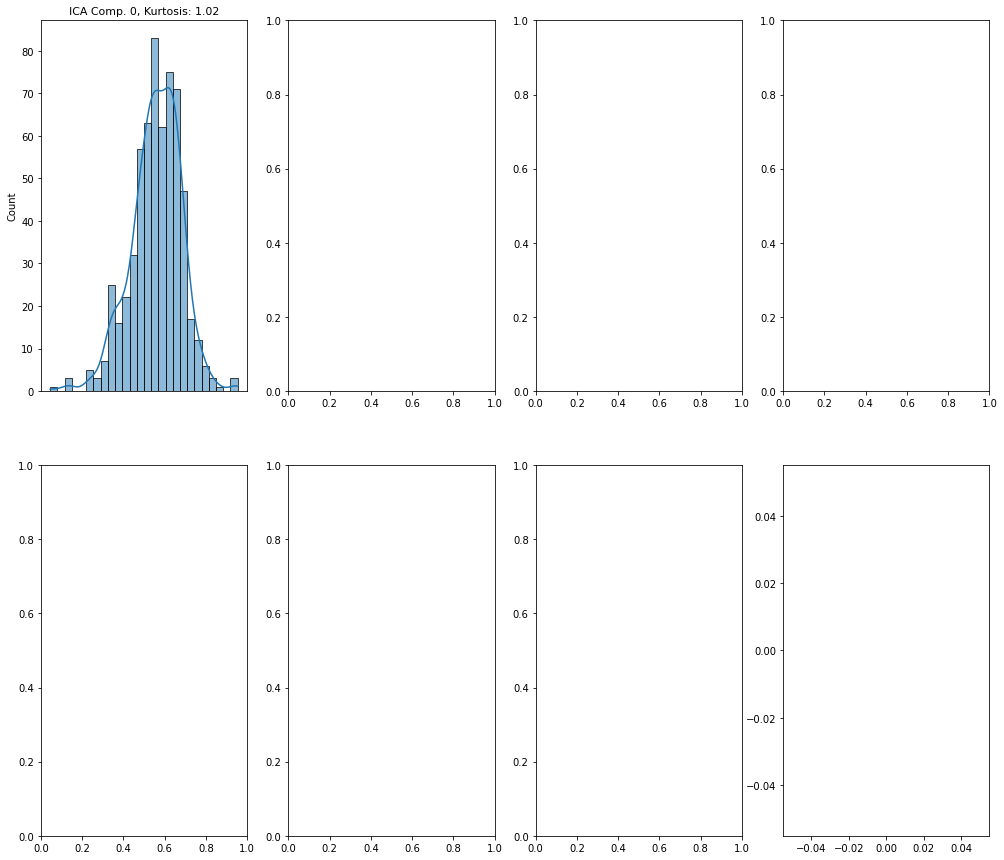

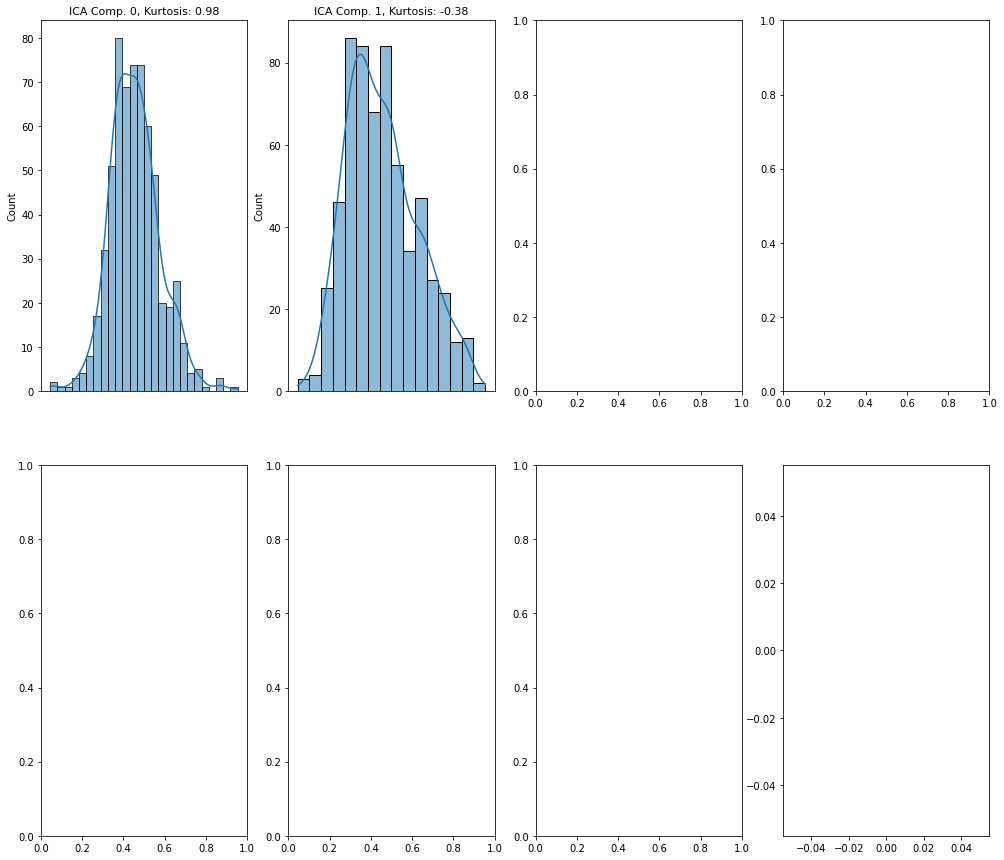

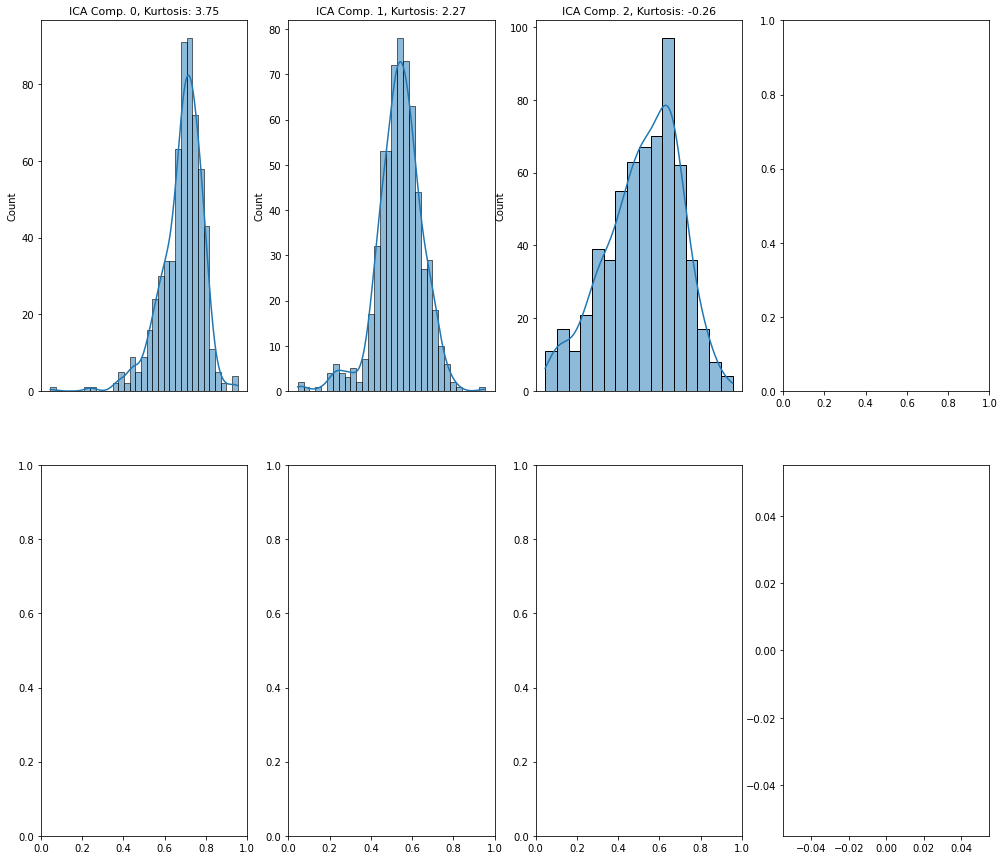

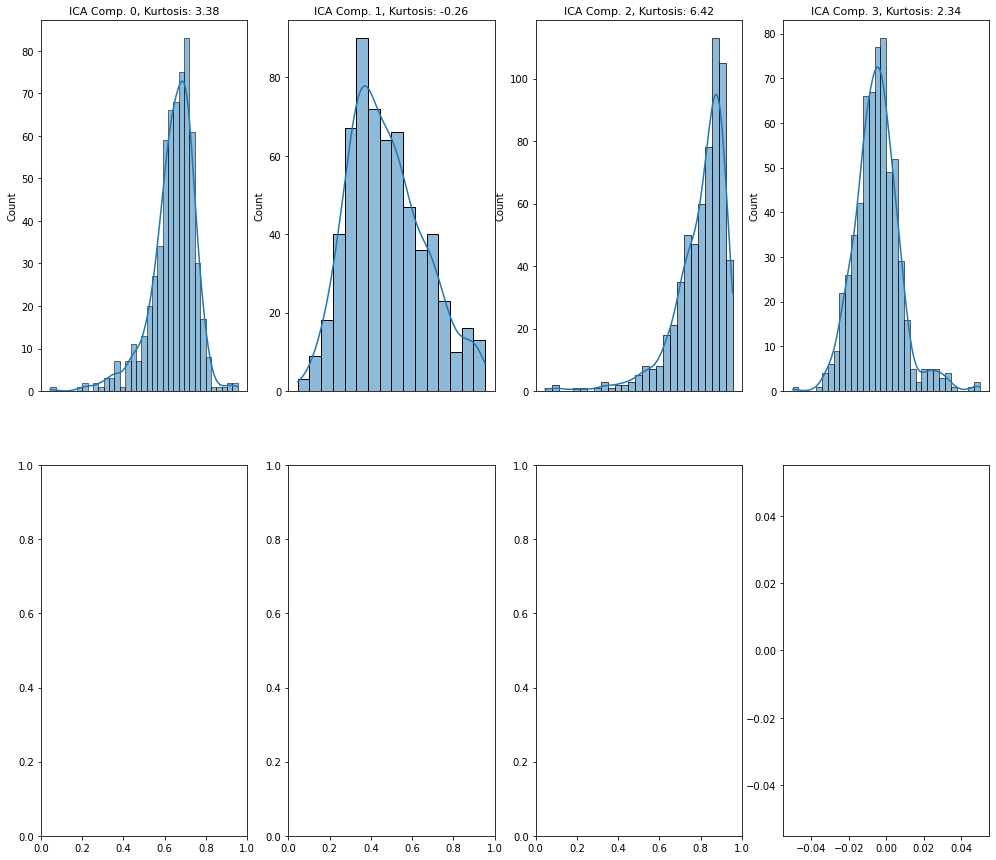

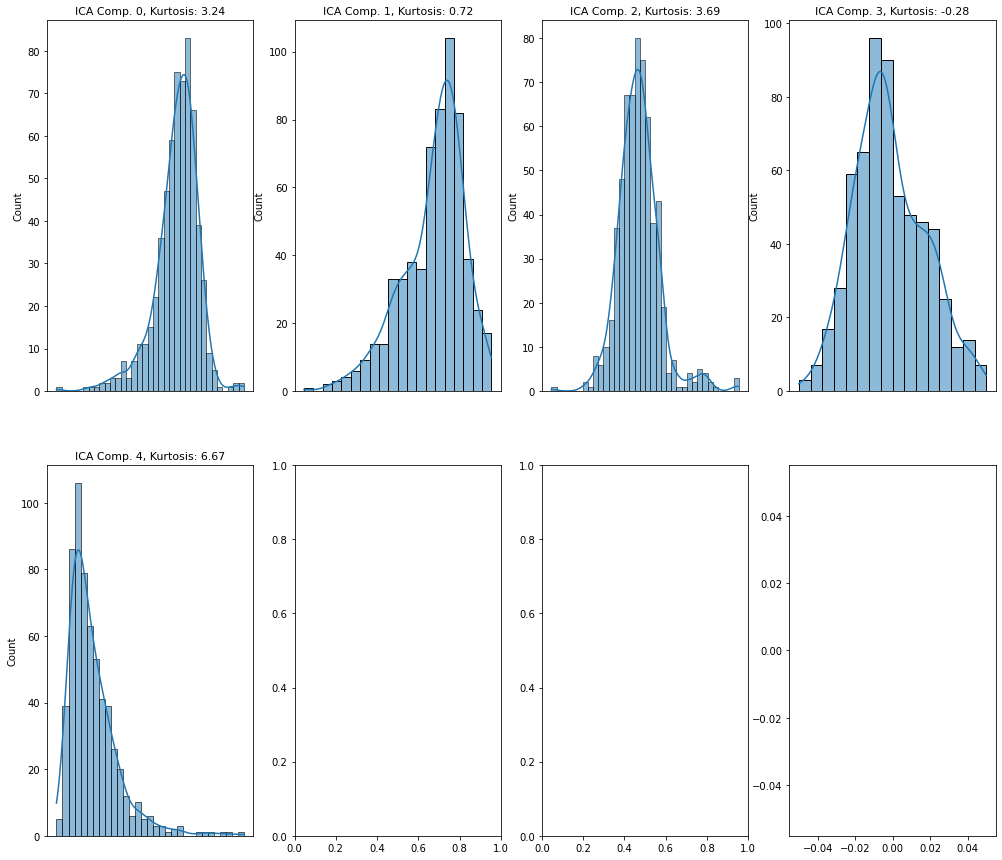

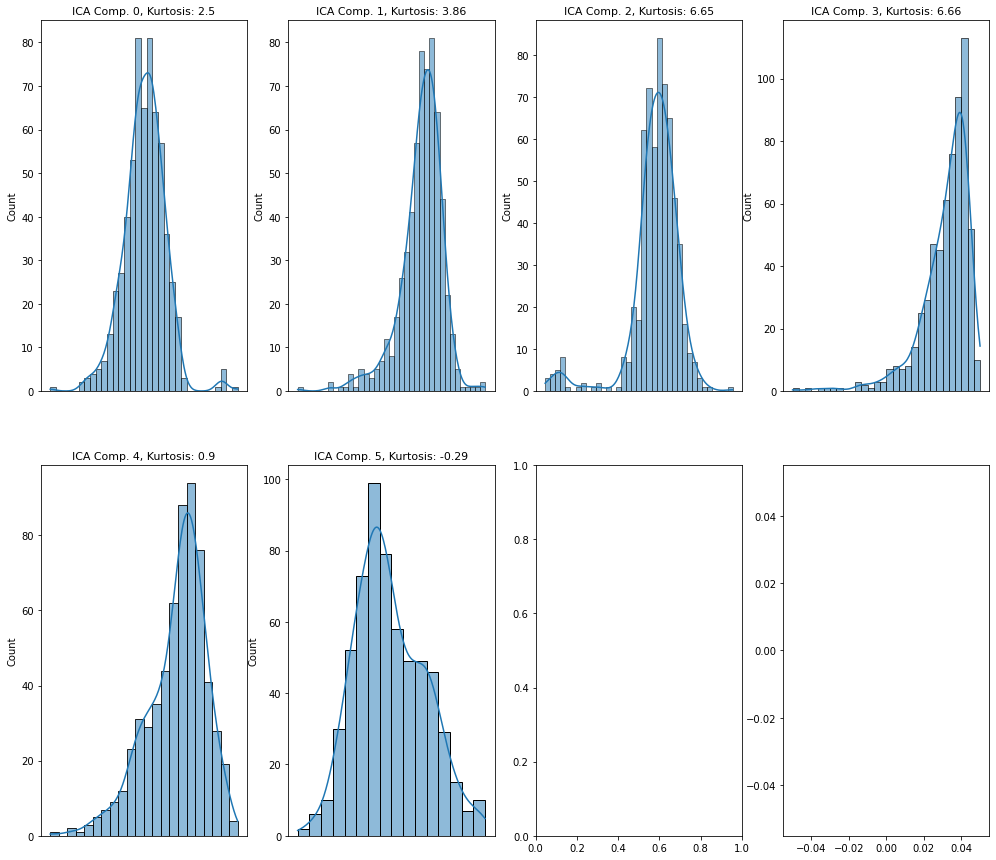

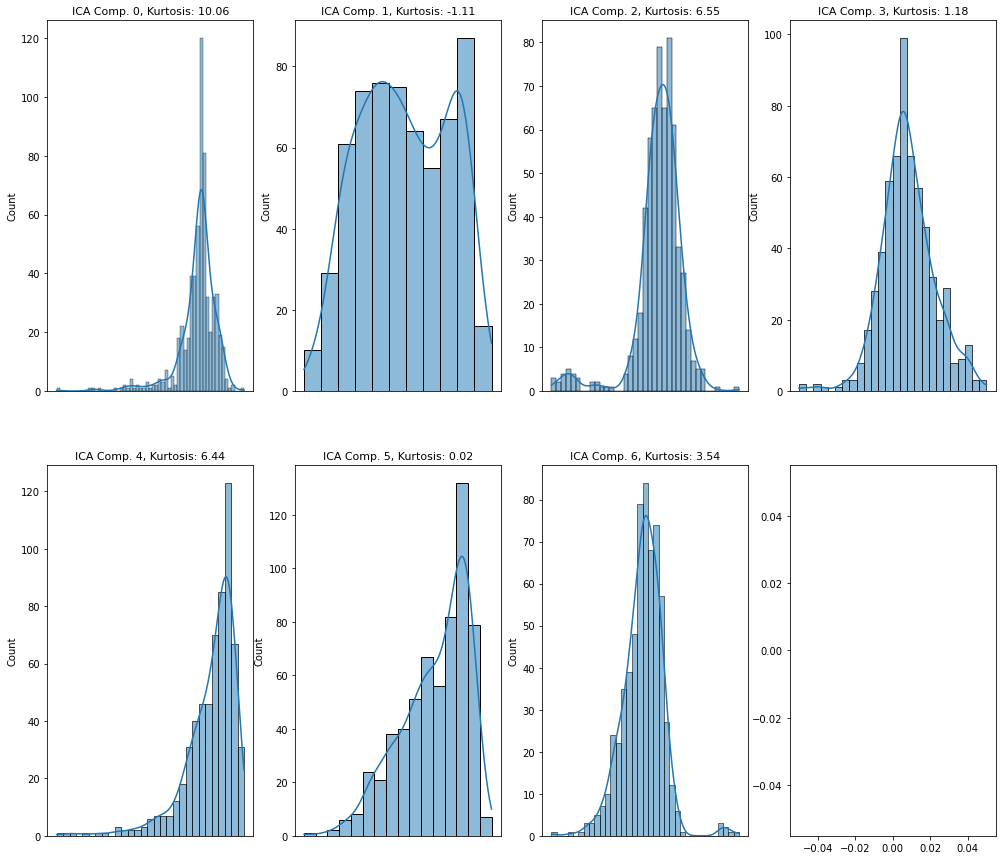

In [100]:
def generateGraphKurtosis(n, X):
    ica = FastICA(n_components=n, max_iter=500)
    S_ = ica.fit_transform(X)
    kurts = []
    for s in range(S_.shape[1]):
        kurts.append(kurtosis(S_[:,s]))

    f, ax = plt.subplots(max(2, math.ceil(n/4)),4, figsize=(17, 15))

    for i in range(0,n):
        sns.histplot(S_[:,i], kde=True, ax=ax[i//4][i%4])
        ax[i//4][i%4].set_title("ICA Comp. {}, Kurtosis: {}".format(i, round(kurts[i],2)), fontsize=11)
#         ax[i//4][i%4].set(ylabel='Distortion')
        ax[i//4][i%4].tick_params(bottom=False)
        ax[i//4][i%4].set(xticklabels=[]) 
    plt.plot()
    
    A_ = ica.mixing_  # Get estimated mixing matrix
    rmse = mean_squared_error(X, np.dot(S_, A_.T) + ica.mean_, squared=False)

    return sum([abs(kurt) for kurt in kurts])/len(kurts), rmse

kurt_avgs = []
rmses = []
for i in range(1,8):
    res = generateGraphKurtosis(i, X_train1)
    kurt_avgs.append(res[0])
    rmses.append(res[1])

[Text(0.5, 0, '# Components'), Text(0, 0.5, 'Avg. Kurtosis')]

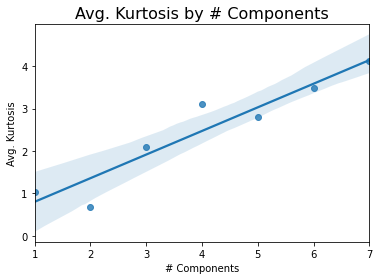

In [79]:
ax = sns.regplot(x=list(range(1,8)), y=kurt_avgs)
ax.set_title("Avg. Kurtosis by # Components", fontsize=16)
ax.set(xlabel="# Components", ylabel="Avg. Kurtosis")

[Text(0.5, 0, '# Components'), Text(0, 0.5, 'RMSE')]

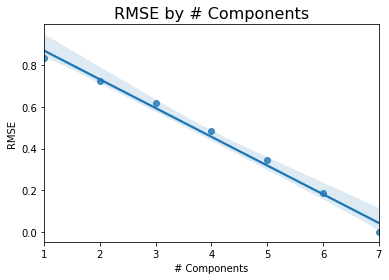

In [80]:
ax = sns.regplot(x=list(range(1,8)), y=rmses)
ax.set_title("RMSE by # Components", fontsize=16)
ax.set(xlabel="# Components", ylabel="RMSE")

/Users/andrewpersonal/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


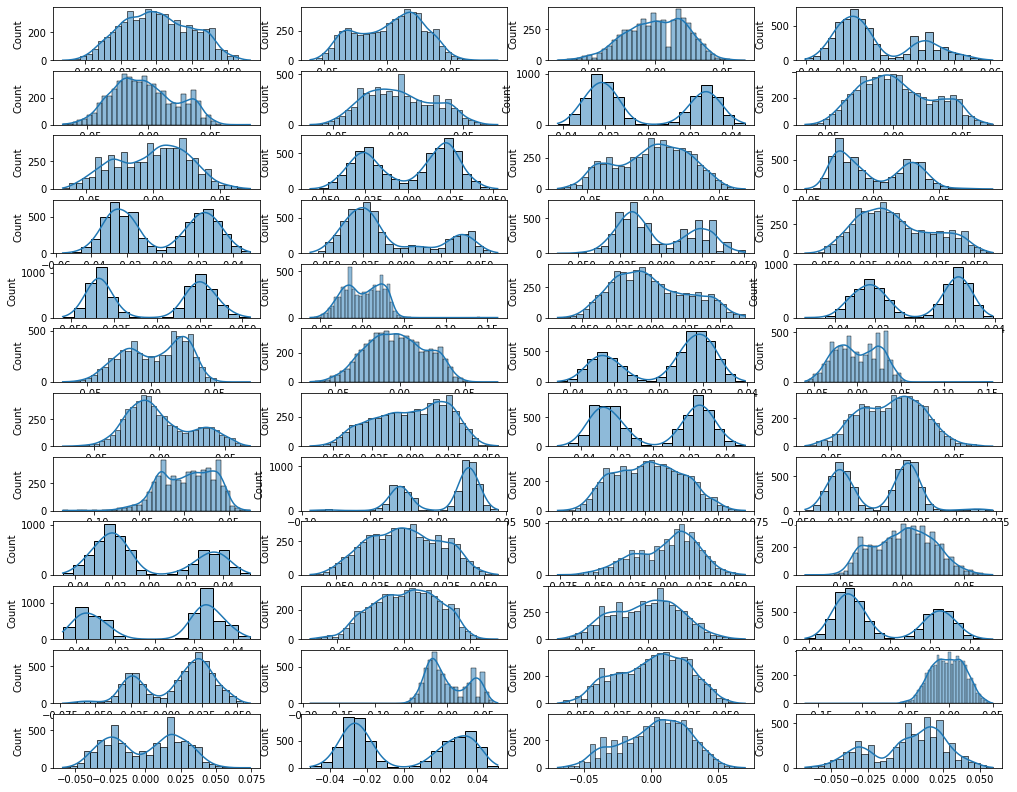

In [86]:
kurt_avgs = []
rmses = []
# for i in range(1,48,2):
res = generateGraphKurtosis(48, X_train2)
kurt_avgs.append(res[0])
rmses.append(res[1])

/Users/andrewpersonal/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


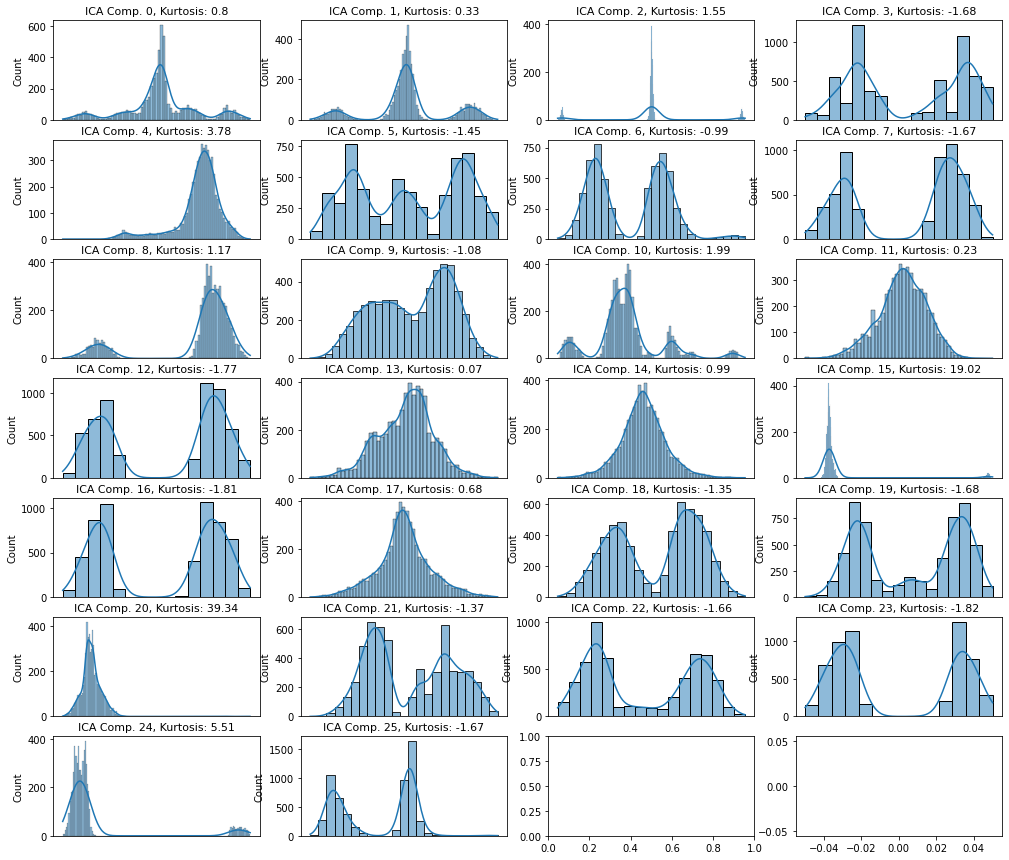

In [101]:
res = generateGraphKurtosis(26, X_train2)

[Text(0.5, 0, '# Components'), Text(0, 0.5, 'Avg. Kurtosis')]

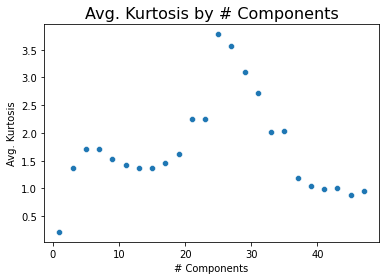

In [74]:
ax = sns.scatterplot(x=list(range(1,48,2)), y=kurt_avgs)
ax.set_title("Avg. Kurtosis by # Components", fontsize=16)
ax.set(xlabel="# Components", ylabel="Avg. Kurtosis")

[Text(0.5, 0, '# Components'), Text(0, 0.5, 'RMSE')]

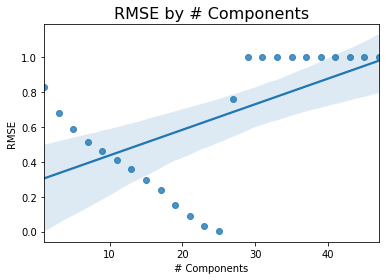

In [82]:
ax = sns.regplot(x=list(range(1,48,2)), y=rmses)
ax.set_title("RMSE by # Components", fontsize=16)
ax.set(xlabel="# Components", ylabel="RMSE")

### 2.3 Randomized Projections

/Users/andrewpersonal/miniconda3/lib/python3.9/site-packages/sklearn/random_projection.py:372: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (7 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/andrewpersonal/miniconda3/lib/python3.9/site-packages/sklearn/random_projection.py:372: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (7 < 20).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/andrewpersonal/miniconda3/lib/python3.9/site-packages/sklearn/random_projection.py:372: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (7 < 30).The dimensionality of the problem will not be reduced.
  warnings.warn(
/Users/andrewpersonal/miniconda3/lib/python3.9/site-packages/sklearn/random_projection.py:372: DataDimensionalityWarning:

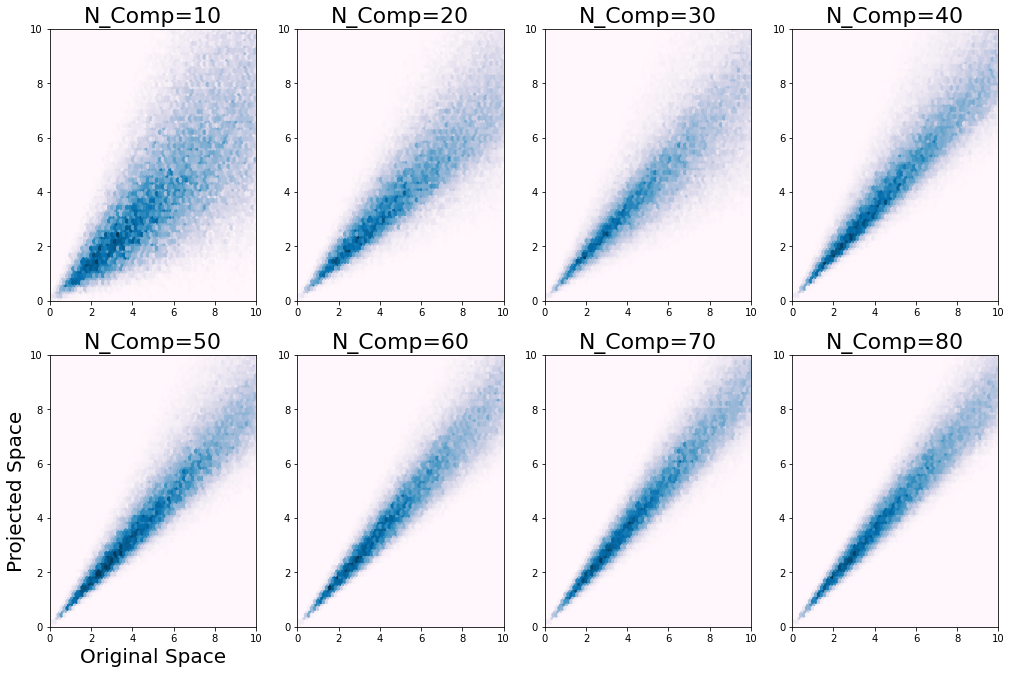

In [144]:
# https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_johnson_lindenstrauss_bound.html
from sklearn.metrics.pairwise import euclidean_distances

f, ax = plt.subplots(2,4, figsize=(17, 11))
for i in range(1,9):
    n_comp = 10*i
    transformer = random_projection.GaussianRandomProjection(n_components=n_comp, random_state=42)
    projected_data = transformer.fit_transform(X_train1)

    dists = euclidean_distances(X_train1, squared=True).ravel()
    nonzero = dists != 0
    dists = dists[nonzero]

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]
    i -= 1
    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    ax[i//4][i%4].hexbin(dists, projected_dists, gridsize=1000, cmap=plt.cm.PuBu,
               extent=[min_dist, max_dist, min_dist, max_dist])
    ax[i//4][i%4].set_title("N_Comp=%d" % n_comp, fontsize=22)
    ax[1][0].set_xlabel("Original Space", fontsize=20)
    ax[1][0].set_ylabel("Projected Space", fontsize=20)
    ax[i//4][i%4].set_xlim(0, 10)
    ax[i//4][i%4].set_ylim(0, 10)

NameError: name 'random_projection' is not defined

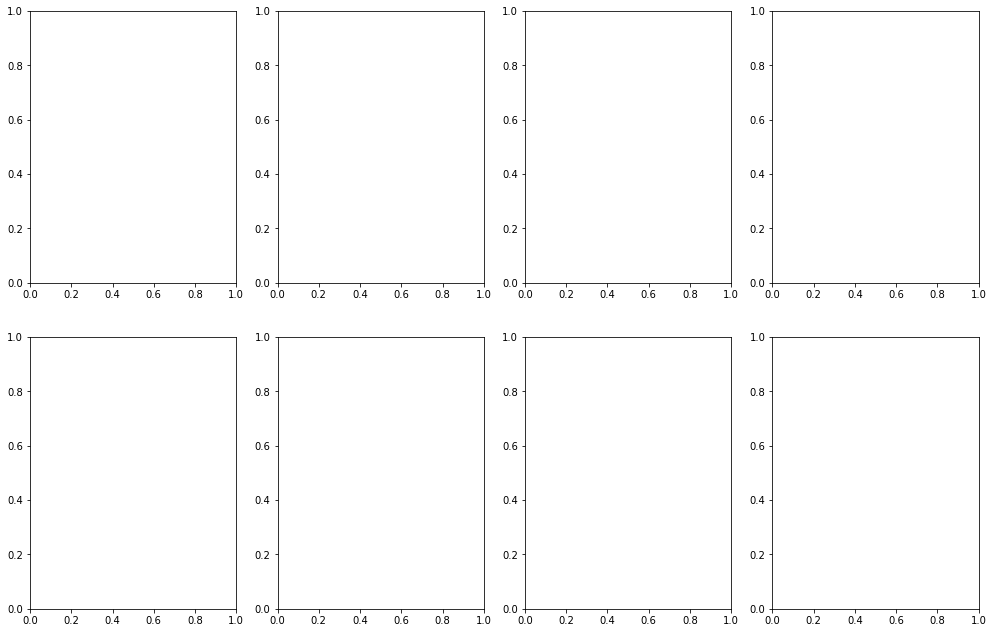

In [10]:
# https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_johnson_lindenstrauss_bound.html
from sklearn.metrics.pairwise import euclidean_distances

f, ax = plt.subplots(2,4, figsize=(17, 11))
for i in range(1,9):
    n_comp = 10*i
    transformer = random_projection.GaussianRandomProjection(n_components=n_comp, random_state=42)
    projected_data = transformer.fit_transform(X_train2)[0:1000]

    dists = euclidean_distances(X_train2[0:1000], squared=True).ravel()
    nonzero = dists != 0
    dists = dists[nonzero]

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]
    i -= 1
    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    ax[i//4][i%4].hexbin(dists, projected_dists, gridsize=1000, cmap=plt.cm.PuBu,
               extent=[min_dist, max_dist, min_dist, max_dist])
    ax[i//4][i%4].set_title("N_Comp=%d" % n_comp, fontsize=22)
    ax[1][0].set_xlabel("Original Space", fontsize=20)
    ax[1][0].set_ylabel("Projected Space", fontsize=20)
    ax[i//4][i%4].set_xlim(0, 100)
    ax[i//4][i%4].set_ylim(0, 100)

### 2.4 Random Forest -> Feature Importance, Top N

In [16]:

model = RandomForestClassifier(n_estimators=100, max_depth=3)
model.fit(X_train1, y_train1)
importance = model.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
importance = sorted(importance)
print(importance)
# Feature 1, Feature 5, Feature 0 (Glucose, BMI, Pregancy)
mask_d1 = np.array(importance)>0.10
print(mask_d1)

Feature: 0, Score: 0.09245
Feature: 1, Score: 0.42985
Feature: 2, Score: 0.03576
Feature: 3, Score: 0.03940
Feature: 4, Score: 0.08235
Feature: 5, Score: 0.26032
Feature: 6, Score: 0.05986
[0.035761697190495295, 0.03940369048367464, 0.059857977452219505, 0.08235013629844593, 0.09245469347363226, 0.2603180651755583, 0.42985373992597414]
[False False False False False  True  True]


In [100]:
model = RandomForestClassifier(n_estimators=100, max_depth=3)
model.fit(X_train2, y_train2)
importance = model.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v), df2.columns[i])
importance = sorted(importance)
print(importance)
# OnlineSecurity, Total Charges, Tenure, Contract 2 Year, Payment method: month to month
mask_d2 = np.array(importance)>0.01
print(mask_d2)

Feature: 0, Score: 0.00079 SeniorCitizen
Feature: 1, Score: 0.13099 tenure
Feature: 2, Score: 0.02921 MonthlyCharges
Feature: 3, Score: 0.05156 TotalCharges
Feature: 4, Score: 0.02651 Long Term Bundle Client
Feature: 5, Score: 0.00027 Bachelor Client
Feature: 6, Score: 0.00006 New Family Client
Feature: 7, Score: 0.00002 gender_Female
Feature: 8, Score: 0.00006 gender_Male
Feature: 9, Score: 0.00176 Partner_No
Feature: 10, Score: 0.00120 Partner_Yes
Feature: 11, Score: 0.00039 Dependents_No
Feature: 12, Score: 0.00100 Dependents_Yes
Feature: 13, Score: 0.00042 PhoneService_No
Feature: 14, Score: 0.00158 PhoneService_Yes
Feature: 15, Score: 0.00027 MultipleLines_No
Feature: 16, Score: 0.00000 MultipleLines_No phone service
Feature: 17, Score: 0.00054 MultipleLines_Yes
Feature: 18, Score: 0.01222 InternetService_DSL
Feature: 19, Score: 0.06727 InternetService_Fiber optic
Feature: 20, Score: 0.00648 InternetService_No
Feature: 21, Score: 0.12989 OnlineSecurity_No
Feature: 22, Score: 0.016

# 3. 2 clustering algos on 8 dim. red. datasets

In [12]:
pca = PCA(n_components=4)
pca.fit(X_train1)
X_train1_pca = pca.transform(X_train1)
X_test1_pca = pca.transform(X_test1)

pca = PCA(n_components=26)
pca.fit(X_train2)
X_train2_pca = pca.transform(X_train2)
X_test2_pca = pca.transform(X_test2)

In [13]:
ica = FastICA(n_components=4)
ica.fit(X_train1)
X_train1_ica = ica.transform(X_train1)
X_test1_ica = ica.transform(X_test1)

ica = FastICA(n_components=26)
ica.fit(X_train2)
X_train2_ica = ica.transform(X_train2)
X_test2_ica = ica.transform(X_test2)

/Users/andrewpersonal/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [14]:
transformer = random_projection.GaussianRandomProjection(n_components=4, random_state=42)
X_train1_rca = transformer.fit_transform(X_train1)
X_test1_rca = transformer.fit_transform(X_test1)

transformer = random_projection.GaussianRandomProjection(n_components=26, random_state=42)
X_train2_rca = transformer.fit_transform(X_train2)
X_test2_rca = transformer.fit_transform(X_test2)

In [110]:
X_train1_rf = X_train1[:,mask_d1]
X_test1_rf = X_test1[:,mask_d1]

X_train2_rf = X_train2[:,mask_d2]
X_test2_rf = X_test2[:,mask_d2]

In [132]:
# Making data with clusters as one hot encodings:
gm = GaussianMixture(n_components=5, random_state=0).fit(X_train2)
a = gm.predict(X_train2)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
X_train2_orig_gm = np.concatenate((X_train2, b), axis=1)

gm = GaussianMixture(n_components=5, random_state=0).fit(X_train2_pca)
a = gm.predict(X_train2_pca)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
X_train2_pca_gm = np.concatenate((X_train2_pca, b), axis=1)

gm = GaussianMixture(n_components=5, random_state=0).fit(X_train2_ica)
a = gm.predict(X_train2_ica)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
X_train2_ica_gm = np.concatenate((X_train2_ica, b), axis=1)

gm = GaussianMixture(n_components=5, random_state=0).fit(X_train2_rca)
a = gm.predict(X_train2_rca)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
X_train2_rca_gm = np.concatenate((X_train2_rca, b), axis=1)

gm = GaussianMixture(n_components=5, random_state=0).fit(X_train2_rf)
a = gm.predict(X_train2_rf)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
X_train2_rf_gm = np.concatenate((X_train2_rf, b), axis=1)

In [122]:
# Making data with clusters as one hot encodings:
gm = KMeans(15, random_state=0).fit(X_train2)
a = gm.predict(X_train2)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
X_train2_orig_km = np.concatenate((X_train2, b), axis=1)

gm = KMeans(15, random_state=0).fit(X_train2_pca)
a = gm.predict(X_train2_pca)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
X_train2_pca_km = np.concatenate((X_train2_pca, b), axis=1)

gm = KMeans(15, random_state=0).fit(X_train2_ica)
a = gm.predict(X_train2_ica)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
X_train2_ica_km = np.concatenate((X_train2_ica, b), axis=1)

gm = KMeans(15, random_state=0).fit(X_train2_rca)
a = gm.predict(X_train2_rca)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
X_train2_rca_km = np.concatenate((X_train2_rca, b), axis=1)

gm = KMeans(15, random_state=0).fit(X_train2_rf)
a = gm.predict(X_train2_rf)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
X_train2_rf_km = np.concatenate((X_train2_rf, b), axis=1)

In [245]:
from scipy import spatial
import random

def computeReconstructionMetric(X1, X2, only1000=True):
    assert X1.shape[0]==X2.shape[0]
    if only1000:
        idxs = range(X1.shape[0])
        idxs = random.sample(idxs, min(1000, X1.shape[0]))
        X1 = np.take(X1, idxs, axis=0)
        X2 = np.take(X2, idxs, axis=0)
    dists1 = euclidean_distances(X1, squared=True).ravel()
    dists2 = euclidean_distances(X2, squared=True).ravel()
    return 1 - spatial.distance.cosine(dists1, dists2)

xs = np.array([[0,1],[1,1],[1,2]])
xs1 = np.array([[0,1],[1,.90],[1,25]])
# print(computeReconstructionMetric(xs, xs1))

print(computeReconstructionMetric(X_train1_pca, X_train1))
print(computeReconstructionMetric(X_train1_ica, X_train1))
print(computeReconstructionMetric(X_train1_rca, X_train1))
print(computeReconstructionMetric(X_train1_rf, X_train1))

print(computeReconstructionMetric(X_train2_pca, X_train2))
print(computeReconstructionMetric(X_train2_ica, X_train2))
print(computeReconstructionMetric(X_train2_rca, X_train2))
print(computeReconstructionMetric(X_train2_rf, X_train2))

0.9713944353747153
0.9608582792112441
0.8737168459804503
0.8711585385898518
1.0
0.9466998223806735
0.9679299069223964
0.9098746398443679


In [240]:
import statistics
recAcc = []
for _ in range(100):
    transformer = random_projection.GaussianRandomProjection(n_components=4)
    X_train1_rca = transformer.fit_transform(X_train1)
    recAcc.append(computeReconstructionMetric(X_train1_rca, X_train1))
print(statistics.stdev(recAcc))
print(sum(recAcc)/len(recAcc))

0.036567589226015954
0.8517810190163883


In [242]:
recAcc = []
for _ in range(100):
    transformer = random_projection.GaussianRandomProjection(n_components=26)
    X_train2_rca = transformer.fit_transform(X_train2)
    recAcc.append(computeReconstructionMetric(X_train2_rca, X_train2))
print(statistics.stdev(recAcc))
print(sum(recAcc)/len(recAcc))

0.006195770565661222
0.9674638750332228


### PCA - clustering

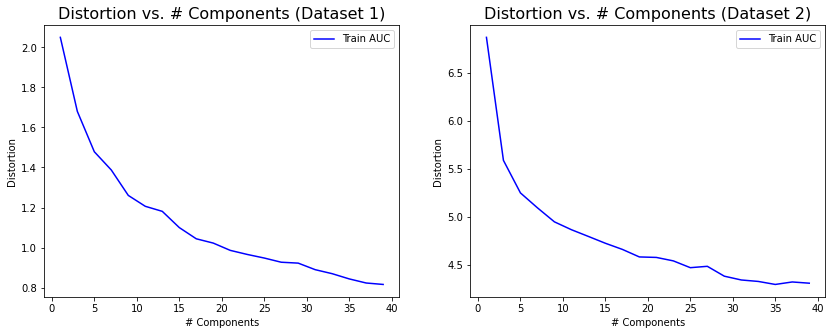

In [185]:
makeDistortionPlotsGM(X_train1_pca, X_train2_pca, 40, 2)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] [0.07295146433975072, 0.06506337061380298, 0.0594840702287312, 0.055592024174696775, 0.051300804378089225, 0.04909206419839609, 0.04736953957051045, 0.04614721568567099, 0.04425968029498504, 0.043568699332414654, 0.042708010527067276, 0.040775898062014114, 0.039844087370585354, 0.03927567974719516, 0.038692547566833824, 0.03811990829441036, 0.0372991561051949, 0.03678567165300197, 0.03629780235304116, 0.03573063124296219, 0.03530848526270113, 0.034606552493908635, 0.034077133601140445, 0.03361335635135026, 0.03339337594552016, 0.03296409257394026, 0.03275614483485107, 0.03217028998308039, 0.031875551214511355, 0.03141341235848946, 0.03147832494475352, 0.03094701064310518, 0.030673080323419685, 0.030464967580573078, 0.030145923497306607, 0.029566930479082165, 0.029441726229192194, 0.029112302029838326, 0.029079173583351835] 39


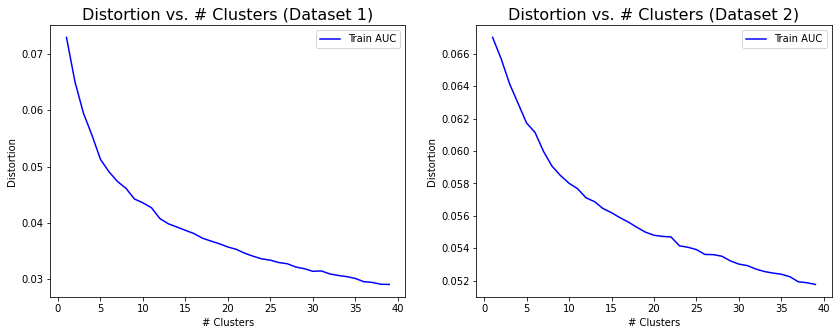

In [197]:
makeDistortionPlotsKMeans(X_train1_ica, X_train2_ica, 40, 1)

### ICA - clustering

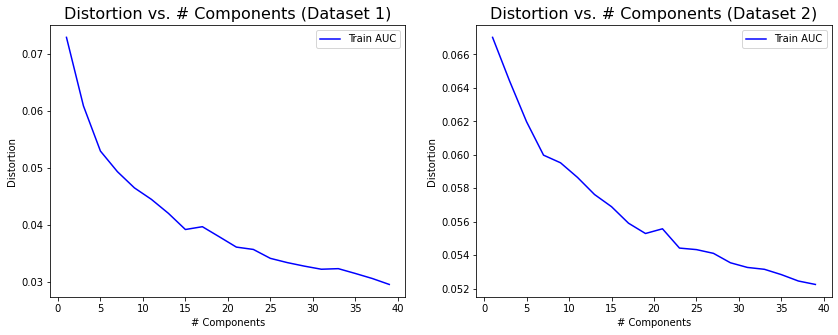

In [186]:
makeDistortionPlotsGM(X_train1_ica, X_train2_ica, 40, 2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


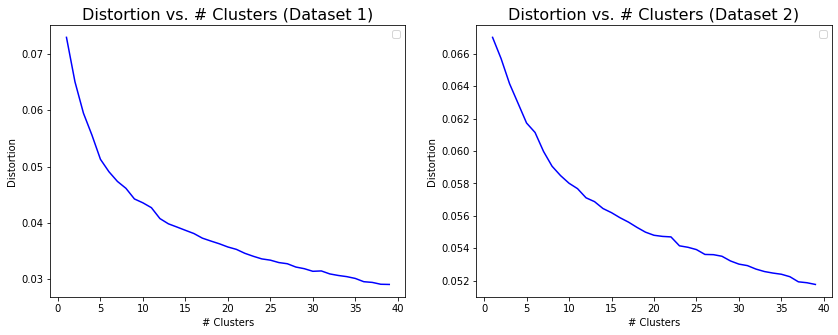

In [203]:
makeDistortionPlotsKMeans(X_train1_ica, X_train2_ica, 40, 1)

### RCA - clustering

No handles with labels found to put in legend.
No handles with labels found to put in legend.


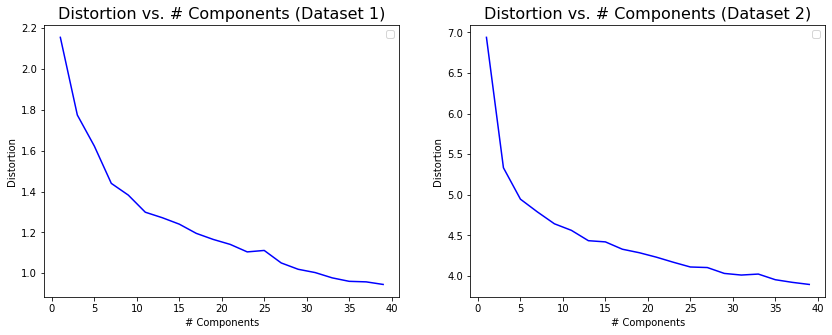

In [202]:
makeDistortionPlotsGM(X_train1_rca, X_train2_rca, 40, 2)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39] [2.1553274109793334, 1.7666207460957772, 1.5615287187114641, 1.3963519574552201, 1.3056966093655238, 1.241045219935574, 1.1871189457233267, 1.1576803135726825, 1.1240505279874078, 1.092869788159581, 1.0746426818841748, 1.0503649944163098, 1.0213537284824332, 1.005818324994227, 0.9814266382436558, 0.9692076662660649, 0.9486754738628519, 0.9240187955621639, 0.9297983159296738, 0.9081049157530723] 20


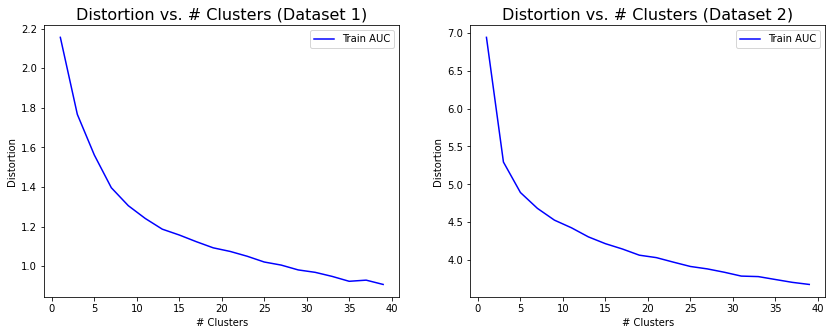

In [193]:
makeDistortionPlotsKMeans(X_train1_rca, X_train2_rca, 40, 2)

### RF - clustering

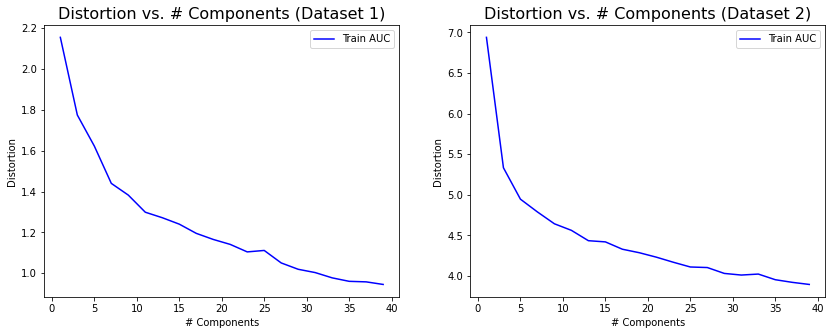

In [194]:
makeDistortionPlotsGM(X_train1_rca, X_train2_rca, 40, 2)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39] [2.1553274109793334, 1.7666207460957772, 1.5615287187114641, 1.3963519574552201, 1.3056966093655238, 1.241045219935574, 1.1871189457233267, 1.1576803135726825, 1.1240505279874082, 1.092869788159581, 1.0746426818841748, 1.0503649944163098, 1.0213537284824332, 1.005818324994227, 0.9814266382436558, 0.9692076662660649, 0.9486754738628519, 0.9240187955621639, 0.9297983159296738, 0.9081049157530723] 20


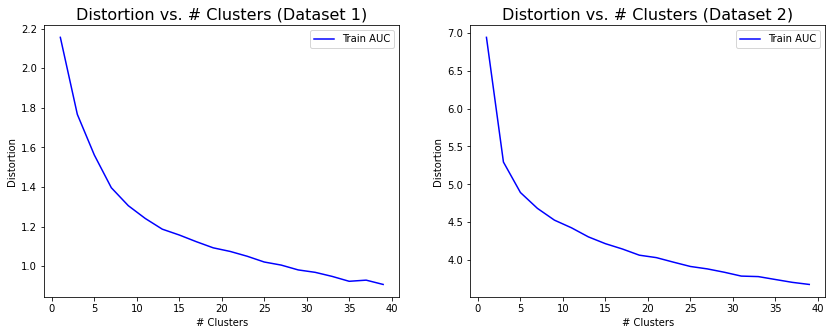

In [195]:
makeDistortionPlotsKMeans(X_train1_rca, X_train2_rca, 40, 2)

[]

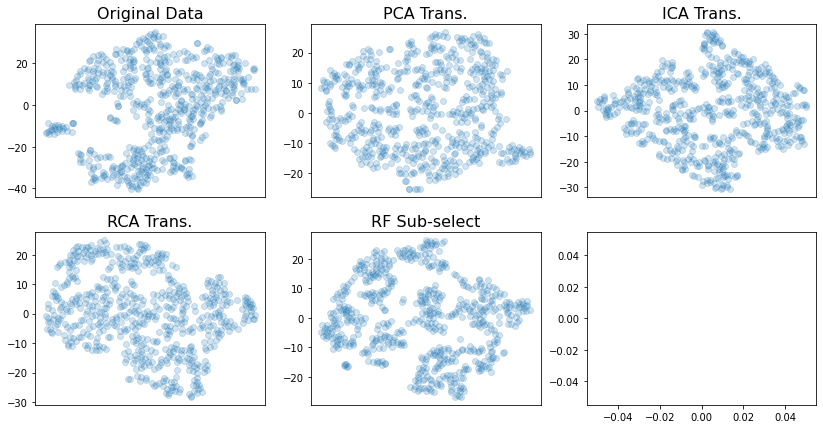

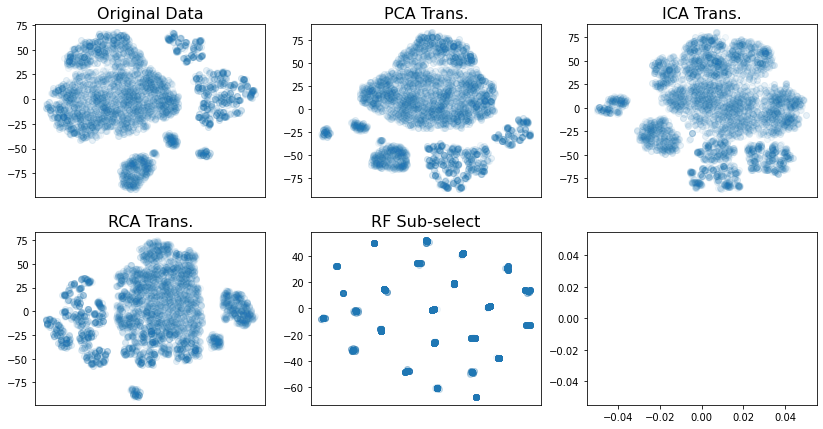

In [262]:
from sklearn.manifold import TSNE

opts = ["Original Data", "PCA Trans.", "ICA Trans.", "RCA Trans.", "RF Sub-select"]

f, ax = plt.subplots(2,3, figsize=(14, 7))
for i, X in enumerate([X_train1, X_train1_pca, X_train1_ica, X_train1_rca, X_train1_rf]):
    X_tsne = TSNE(n_components=2).fit_transform(X)
    ax[i//3][i%3].set_title(opts[i], fontsize=16)
    ax[i//3][i%3].scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.2)
    ax[i//3][i%3].tick_params(bottom=False)
    ax[i//3][i%3].set(xticklabels=[]) 
plt.plot()

f, ax = plt.subplots(2,3, figsize=(14, 7))
for i, X in enumerate([X_train2, X_train2_pca, X_train2_ica, X_train2_rca, X_train2_rf]):
    X_tsne = TSNE(n_components=2).fit_transform(X)
    ax[i//3][i%3].set_title(opts[i], fontsize=16)
    ax[i//3][i%3].scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.05)
    ax[i//3][i%3].tick_params(bottom=False)
    ax[i//3][i%3].set(xticklabels=[]) 
plt.plot()

# 4. NN reruns on 4 dim. red. algos. on 1 dataset

In [125]:
def varyDatasetSizeAndTrainTooLong(X, y, n, opt, ax, k):
    train_szs = np.logspace(-2, -0.05, n) #np.linspace(0.01, 0.9, 50)
    n = 1
    scores_tr = []
    scores_val = []
    for train_sz in train_szs:
        avg_score_tr = 0
        avg_score_val = 0
        worked = 0
        for i in range(n):
            X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=1-train_sz, random_state=42)
            data = [X_train11, X_test11, y_train11, y_test11]
            if (y_train11.sum()==0) or (y_test11.sum()==0) or ((y_train11==0).sum()==0) or ((y_test11==0).sum()==0): continue

            net, aucs = training_loop(*data, use_early_stopping=True)
            auc, acc = evaluate(net, X_test=X_test11, y_test=y_test11)
            avg_score_val += auc
            auc, acc = evaluate(net, X_test=X_train11, y_test=y_train11)
            avg_score_tr += auc
            worked += 1
        avg_score_tr /= worked
        avg_score_val /= worked
        scores_tr.append(avg_score_tr)
        scores_val.append(avg_score_val)
    
    train_szs_ma, aucs_tr_ma, aucs_val_ma = compute_moving_averages(train_szs, scores_tr, scores_val)
    
#     ax[0][k].plot(np.array(train_szs_ma)*100, aucs_tr_ma, '-', color="b", label="Train AUC")
#     ax[0][k].plot(np.array(train_szs_ma)*100, aucs_val_ma, '-', color="r", label="Val AUC")
    ax[0][k].plot(np.array(train_szs)*100, scores_tr, '-', color="b", label="Train AUC")
    ax[0][k].plot(np.array(train_szs)*100, scores_val, '-', color="r", label="Val AUC")
    ax[0][k].legend()
    ax[0][k].set_title("{}".format(opt), fontsize=16)
    ax[0][k].set(xlabel='Dataset Size (%)', ylabel='AUC')
    
    # TRAIN TOO LONG
    epoch, aucs_tr_ma, aucs_val_ma = trainTooLong(X, y)
    ax[1][k].plot(epoch, aucs_tr_ma, '-', color="b", label="Train score")
    ax[1][k].plot(epoch, aucs_val_ma, '-', color="r", label="Val score")
    ax[1][k].legend()
    ax[1][k].set(xlabel='Epochs', ylabel='AUC')
    
    return ax
    

Running:  Original
# of positive examples: 31, # of negative examples: 43
~ Epoch:  0 , Val AUC:  0.5373867471520652
~ Epoch:  10 , Val AUC:  0.7601641579449906
~ Epoch:  20 , Val AUC:  0.7893100288033515
~ Epoch:  30 , Val AUC:  0.7931767597419599
~ Epoch:  40 , Val AUC:  0.7937851776471179
# of positive examples: 49, # of negative examples: 73
~ Epoch:  0 , Val AUC:  0.43424240113753865
~ Epoch:  10 , Val AUC:  0.7554061176143257
~ Epoch:  20 , Val AUC:  0.7849807511982012
~ Epoch:  30 , Val AUC:  0.7800204058701489
# of positive examples: 89, # of negative examples: 113
~ Epoch:  0 , Val AUC:  0.5819451273293031
~ Epoch:  10 , Val AUC:  0.7854515965125166
~ Epoch:  20 , Val AUC:  0.8020681253543773
~ Epoch:  30 , Val AUC:  0.8032702690117427
~ Epoch:  40 , Val AUC:  0.7989302599177708
# of positive examples: 147, # of negative examples: 187
~ Epoch:  0 , Val AUC:  0.7480970988876822
~ Epoch:  10 , Val AUC:  0.822681754296301
~ Epoch:  20 , Val AUC:  0.8211569312236915
# of positive 

~ Epoch:  30 , Val AUC:  0.7519834024230214
~ Epoch:  40 , Val AUC:  0.7562357122123549
# of positive examples: 89, # of negative examples: 113
~ Epoch:  0 , Val AUC:  0.30021029810149635
~ Epoch:  10 , Val AUC:  0.7274855715369634
~ Epoch:  20 , Val AUC:  0.7854361032056251
~ Epoch:  30 , Val AUC:  0.7956316407223681
~ Epoch:  40 , Val AUC:  0.7982312635416637
# of positive examples: 147, # of negative examples: 187
~ Epoch:  0 , Val AUC:  0.5735382638755794
~ Epoch:  10 , Val AUC:  0.8006306920221186
~ Epoch:  20 , Val AUC:  0.8094181449065497
~ Epoch:  30 , Val AUC:  0.810462140732696
~ Epoch:  40 , Val AUC:  0.8104653350085536
# of positive examples: 246, # of negative examples: 306
~ Epoch:  0 , Val AUC:  0.7365222262225872
~ Epoch:  10 , Val AUC:  0.8004610950246935
~ Epoch:  20 , Val AUC:  0.8083588789253162
~ Epoch:  30 , Val AUC:  0.809109151876277
~ Epoch:  40 , Val AUC:  0.8094947664968957
# of positive examples: 408, # of negative examples: 501
~ Epoch:  0 , Val AUC:  0.714

[]

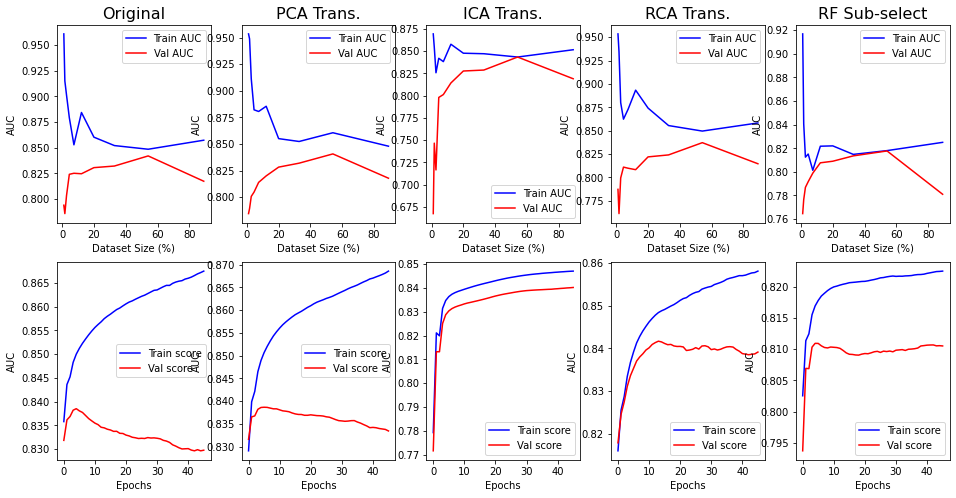

In [134]:
f, ax = plt.subplots(2,5,figsize=(16, 8))

data = [[X_train2, y_train2, "Original"],
        [X_train2_pca, y_train2, "PCA Trans."],
        [X_train2_ica, y_train2, "ICA Trans."],
        [X_train2_rca, y_train2, "RCA Trans."],
        [X_train2_rf, y_train2, "RF Sub-select"]]

k = 0
for X, y, opt in data:
    print("Running: ", opt)
    ax = varyDatasetSizeAndTrainTooLong(X, y, 10, opt, ax, k)
    k += 1
plt.plot()

Running:  Original
# of positive examples: 31, # of negative examples: 43
~ Epoch:  0 , Val AUC:  0.41824007289443266
~ Epoch:  10 , Val AUC:  0.7108953669980772
~ Epoch:  20 , Val AUC:  0.7743620910598523
~ Epoch:  30 , Val AUC:  0.7957873114491341
~ Epoch:  40 , Val AUC:  0.8011791785358164
# of positive examples: 49, # of negative examples: 73
~ Epoch:  0 , Val AUC:  0.7034458063963809
~ Epoch:  10 , Val AUC:  0.8000435405488919
~ Epoch:  20 , Val AUC:  0.8043450926256623
~ Epoch:  30 , Val AUC:  0.8072786454675693
~ Epoch:  40 , Val AUC:  0.8055635257277157
# of positive examples: 89, # of negative examples: 113
~ Epoch:  0 , Val AUC:  0.6224868315451262
~ Epoch:  10 , Val AUC:  0.8135839322937353
~ Epoch:  20 , Val AUC:  0.8158220731516913
# of positive examples: 147, # of negative examples: 187
~ Epoch:  0 , Val AUC:  0.7397610149279158
~ Epoch:  10 , Val AUC:  0.8249133109024184
~ Epoch:  20 , Val AUC:  0.8249448100115704
# of positive examples: 246, # of negative examples: 306


~ Epoch:  40 , Val AUC:  0.8026880288267954
# of positive examples: 147, # of negative examples: 187
~ Epoch:  0 , Val AUC:  0.3972035002165009
~ Epoch:  10 , Val AUC:  0.7941177410081135
~ Epoch:  20 , Val AUC:  0.8042351661378366
~ Epoch:  30 , Val AUC:  0.8070082412317129
~ Epoch:  40 , Val AUC:  0.8073943936909502
# of positive examples: 246, # of negative examples: 306
~ Epoch:  0 , Val AUC:  0.6002954836928911
~ Epoch:  10 , Val AUC:  0.7974304567395146
~ Epoch:  20 , Val AUC:  0.8129991868581782
~ Epoch:  30 , Val AUC:  0.8166246250759194
~ Epoch:  40 , Val AUC:  0.8158867182241752
# of positive examples: 408, # of negative examples: 501
~ Epoch:  0 , Val AUC:  0.7781125805283685
~ Epoch:  10 , Val AUC:  0.8119428957367111
~ Epoch:  20 , Val AUC:  0.8160628736604507
~ Epoch:  30 , Val AUC:  0.8163020751516903
# of positive examples: 661, # of negative examples: 837
~ Epoch:  0 , Val AUC:  0.7752107250755288
~ Epoch:  10 , Val AUC:  0.8198787764350453
~ Epoch:  20 , Val AUC:  0.8

[]

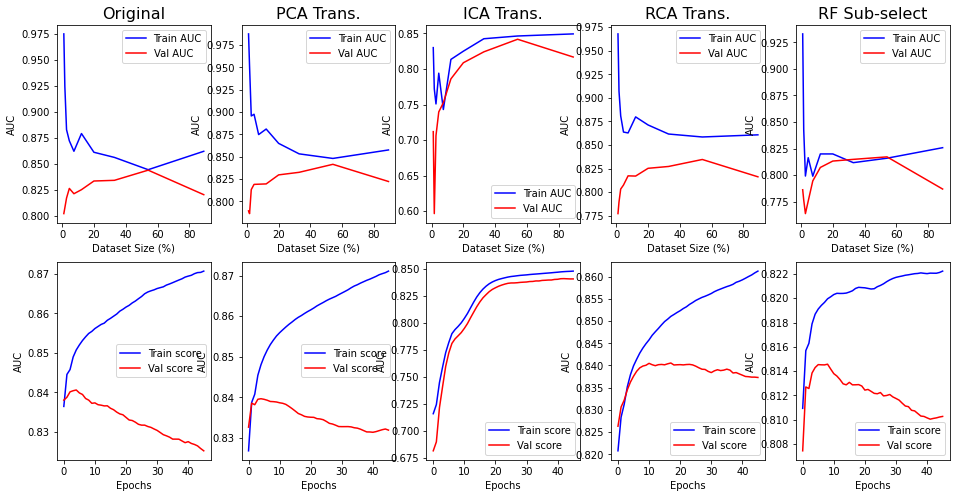

In [135]:
f, ax = plt.subplots(2,5,figsize=(16, 8))

data = [[X_train2_orig_gm, y_train2, "Original"],
        [X_train2_pca_gm, y_train2, "PCA Trans."],
        [X_train2_ica_gm, y_train2, "ICA Trans."],
        [X_train2_rca_gm, y_train2, "RCA Trans."],
        [X_train2_rf_gm, y_train2, "RF Sub-select"]]

k = 0
for X, y, opt in data:
    print("Running: ", opt)
    ax = varyDatasetSizeAndTrainTooLong(X, y, 10, opt, ax, k)
    k += 1
plt.plot()

Running:  Original
# of positive examples: 31, # of negative examples: 43
~ Epoch:  0 , Val AUC:  0.485313828253734
~ Epoch:  10 , Val AUC:  0.7959751018961545
~ Epoch:  20 , Val AUC:  0.7974341146473902
# of positive examples: 49, # of negative examples: 73
~ Epoch:  0 , Val AUC:  0.6114895549500454
~ Epoch:  10 , Val AUC:  0.8004595500943713
~ Epoch:  20 , Val AUC:  0.8046908754793809
# of positive examples: 89, # of negative examples: 113
~ Epoch:  0 , Val AUC:  0.5725651711830655
~ Epoch:  10 , Val AUC:  0.8118206056530541
~ Epoch:  20 , Val AUC:  0.8106651131131241
# of positive examples: 147, # of negative examples: 187
~ Epoch:  0 , Val AUC:  0.7024886070827743
~ Epoch:  10 , Val AUC:  0.8239824456795645
~ Epoch:  20 , Val AUC:  0.8248580321841039
# of positive examples: 246, # of negative examples: 306
~ Epoch:  0 , Val AUC:  0.6443381484343479
~ Epoch:  10 , Val AUC:  0.8176731947713489
~ Epoch:  20 , Val AUC:  0.8100190513446104
# of positive examples: 408, # of negative exam

~ Epoch:  40 , Val AUC:  0.7974209771644769
# of positive examples: 246, # of negative examples: 306
~ Epoch:  0 , Val AUC:  0.634792747009056
~ Epoch:  10 , Val AUC:  0.8044877234842042
~ Epoch:  20 , Val AUC:  0.809454175484199
# of positive examples: 408, # of negative examples: 501
~ Epoch:  0 , Val AUC:  0.7631443214532027
~ Epoch:  10 , Val AUC:  0.8099125181973742
~ Epoch:  20 , Val AUC:  0.8088922891855725
# of positive examples: 661, # of negative examples: 837
~ Epoch:  0 , Val AUC:  0.7726299093655589
~ Epoch:  10 , Val AUC:  0.8190533736153072
~ Epoch:  20 , Val AUC:  0.8207401812688822
~ Epoch:  30 , Val AUC:  0.818056143001007
# of positive examples: 1096, # of negative examples: 1372
~ Epoch:  0 , Val AUC:  0.7927123552123552
~ Epoch:  10 , Val AUC:  0.8228467753467754
~ Epoch:  20 , Val AUC:  0.8233658658658659
# of positive examples: 1799, # of negative examples: 2265
~ Epoch:  0 , Val AUC:  0.8173395082600714
~ Epoch:  10 , Val AUC:  0.8347147920490774
~ Epoch:  20 , 

[]

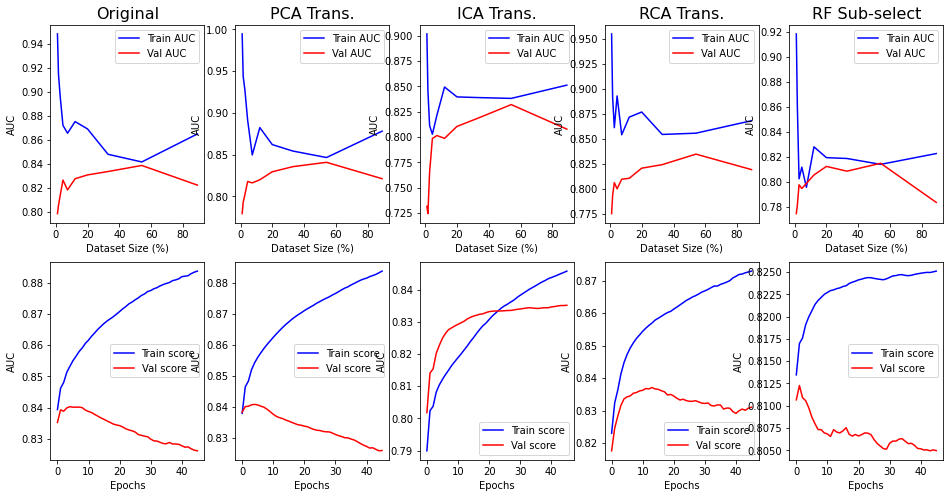

In [131]:
f, ax = plt.subplots(2,5,figsize=(16, 8))

data = [[X_train2_orig_km, y_train2, "Original"],
        [X_train2_pca_km, y_train2, "PCA Trans."],
        [X_train2_ica_km, y_train2, "ICA Trans."],
        [X_train2_rca_km, y_train2, "RCA Trans."],
        [X_train2_rf_km, y_train2, "RF Sub-select"]]

k = 0
for X, y, opt in data:
    print("Running: ", opt)
    ax = varyDatasetSizeAndTrainTooLong(X, y, 10, opt, ax, k)
    k += 1
plt.plot()

# ________________ CODE UTILS _________________________________

In [133]:
import numpy as np
import torch
import copy
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        minority_mask = y == 1
        minority_idxs = np.argwhere(minority_mask)[:,0]
        minority_idxs_sampled = np.random.choice(minority_idxs, size=int(y.shape[0]/3), replace=True)
        self.X = np.concatenate([X, X[minority_idxs_sampled]])
        self.y = np.concatenate([y, y[minority_idxs_sampled]]).reshape((-1,1))
        print("# of positive examples: {}, # of negative examples: {}".format((self.y==1).sum(),(self.y==0).sum()))
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.squeeze(torch.from_numpy(self.y[idx]).long(), 0)

class MiniNet(torch.nn.Module):
    def __init__(self, input_size):
        super(MiniNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 18)
        self.relu = torch.nn.ReLU()

        self.drop = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(18, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

def training_loop(X_tr, X_val, y_tr, y_val, use_early_stopping=True):
    h=30
    lr=0.0003

    input_size = X_tr.shape[1]
    net = MiniNet(input_size)
    net = net.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    batch_size = 64
    early = 10
    auc_avg = 0
    epochs = 50
    best_net = copy.deepcopy(net)
    verbose_train = False

    dataset_train = MyDataset(X_tr, y_tr)

    best = 0
    aucs = []

    import time
    tic = time.time()
    for j, epoch in enumerate(range(epochs)):
        loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True)
        net = net.train()
        for i, (X_batch, y_batch) in enumerate(iter(loader_train)):
            optimizer.zero_grad()
            output = net(X_batch)
            
            loss = criterion(output, y_batch)
            loss = loss.mean()
            
            loss.backward()
            optimizer.step()
        if j == 0:
            print(time.time()-tic)
            
        # Run on training
        net = net.eval()
        outputs = net(torch.from_numpy(X_tr).float())
        yhat = torch.nn.functional.softmax(outputs, dim=1)[:,1]
        auc_tr = roc_auc_score(y_tr, yhat.detach())

        # Run on validation
        net = net.eval()
        outputs = net(torch.from_numpy(X_val).float())
        yhat = torch.nn.functional.softmax(outputs, dim=1)[:,1]
        auc = roc_auc_score(y_val, yhat.detach())
        if epoch%10==0: print("~ Epoch: ", epoch,", Val AUC: ", auc)

        if use_early_stopping:
            if auc > best:
                best = auc
                early_cnt = 0
                best_net = copy.deepcopy(net)
            elif early_cnt >= early:
                if verbose_train: print("Early Stopping, best AUC was {}".format(best))
                auc_avg+=best
                break
            else:
                early_cnt += 1

        # Check if end
        if epoch==epochs-1:
            if verbose_train: print("Finished epochs, best AUC was {}".format(best))
            auc_avg+=best
            break
            
        aucs.append([j, auc_tr, auc])

        if verbose_train: print("Batch {}, Validation AUC: {}".format(epoch, auc))
    return best_net, aucs


# Predict on val set
def evaluate(net, X_test, y_test):
    net = net.eval()
    outputs = net(torch.from_numpy(X_test).float())
    yhat = torch.nn.functional.softmax(outputs, dim=1)[:,1]
    yhat = yhat.detach().numpy()
    auc = roc_auc_score(y_test, yhat)
    t = 0.5
    yhat[yhat>t] = 1
    yhat[yhat<=t] = 0
    return auc, accuracy_score(y_test, yhat)

def trainTooLong(X, y):
    h=30
    n_folds = 5
    skf = StratifiedKFold(n_splits=n_folds)

    for train_index, test_index in skf.split(X, y):
        print("new training")
        X_tr, X_val = X[train_index], X[test_index]
        y_tr, y_val = y[train_index], y[test_index]
        data = [X_tr, X_val, y_tr, y_val]
        net, aucs = training_loop(*data, use_early_stopping=False)
        break

    epoch = [e[0] for e in aucs][:-3]
    aucs_tr = [e[1] for e in aucs]
    aucs_tr_ma = aucs_tr[0:2]
    aucs_val = [e[2] for e in aucs]
    aucs_val_ma = aucs_val[0:2]

    for i in range(2, len(aucs_tr)-3):
        aucs_tr_ma.append(sum(aucs_tr[i-2:i+3])/5)
        aucs_val_ma.append(sum(aucs_val[i-2:i+3])/5)
        
    return epoch, aucs_tr_ma, aucs_val_ma

def compute_moving_averages(x, y1, y2):
    x_ma = x[:-3]
    y1_ma = y1[0:2]
    y2_ma = y2[0:2]
    for i in range(2, len(x)-3):
        y1_ma.append(sum(y1[i-2:i+3])/5)
        y2_ma.append(sum(y2[i-2:i+3])/5)
    return x_ma, y1_ma, y2_ma